In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import data_loader
import datetime
import pickle
import random
import gzip
import time
import math
import os
from utils import *
tf.keras.backend.set_floatx('float32')
#physical_devices = tf.config.list_physical_devices('CPU')
#tf.config.set_visible_devices(physical_devices[0],'GPU')

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.makedirs('./hgvae_samples', exist_ok=True)

2023-10-06 02:18:51.358558: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 02:18:51.467235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 02:18:53.174222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def sample_generation(no_samples,temp):
    n_zrand = 12
    n_z     = 6
    zrand   = tf.random.normal([no_samples,n_zrand],mean=0.0,stddev=1.0,dtype=tf.float32)
    tz      = tf.cast(tf.repeat(temp,no_samples*n_z),tf.float32)
    tz      = tf.reshape(tz,[no_samples,n_z])
    z       = tf.concat([tz,zrand],axis=-1)
    [mean_samples,log_samples,samples] = hg_vae.decoder(z)
    return samples

In [3]:
def samples_generation_for_all_temp(no_samples,temp_array):
    samples = []
    for i in temp_array:
        samples.append(sample_generation(no_samples,i))
    samples = tf.concat(samples,axis=0)
    return samples
        

In [4]:
(l,l) = (8,8)
lattice_size  = 8
learning_rate = 1e-4
n_z           = 6   # no of temp variables
n_zrand       = 2*6 # no of noise variables
latent_dim    = n_z + n_zrand

num_classes = 32


In [5]:
BATCH_SIZE = 256
xy_data = np.float32(data_loader.load_data_mh_generated('./data/8x8_gibbslattices.pkl'))/(2*np.pi)
trainset  = []
   
for i in range(num_classes):
    trainset.append(xy_data[10000*i:10000*i+5000])

trainset = np.reshape(np.array(trainset),(-1,l,l,1))

temp_val = np.linspace(0.05,2.05,num_classes)
Temp = np.float32(np.repeat(temp_val,5000))
T = np.repeat(Temp,l*l).reshape(-1,l,l,1)
T_z = np.repeat(Temp,n_z).reshape(-1,n_z)

training_dataset = tf.data.Dataset.from_tensor_slices((trainset,T,T_z))
training_dataset = training_dataset.shuffle(buffer_size = 1024).batch(BATCH_SIZE)


2023-10-06 02:19:08.104793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-06 02:19:08.104885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: MADHAVLAB2
2023-10-06 02:19:08.104893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: MADHAVLAB2
2023-10-06 02:19:08.105168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-10-06 02:19:08.105212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-10-06 02:19:08.105223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [6]:
#Plotting Comparison Plots for different epochs
lattices1=[]
index_set = np.arange(num_classes)
for i in index_set:
    lattices1.append(xy_data[10000*i+5000:10000*i+6000])
lattices1=np.array(lattices1)
lattices1=tf.reshape(lattices1,(-1,l,l,1))



In [7]:
def xy_action(lattice, J=1, K=1):
    xp = tf.roll(lattice,shift=[0,1,0], axis=[0,1,2])
    xn = tf.roll(lattice,shift=[0,-1,0], axis=[0,1,2])
    yp = tf.roll(lattice,shift=[0,0,1], axis=[0,1,2])
    yn = tf.roll(lattice,shift=[0,0,-1], axis=[0,1,2])
    xp_yp = tf.roll(lattice,shift=[0,1,1],axis=[0,1,2])
    xp_yn = tf.roll(lattice,shift=[0,1,-1],axis=[0,1,2])
    xn_yp = tf.roll(lattice,shift=[0,-1,1],axis=[0,1,2])
    xn_yn = tf.roll(lattice,shift=[0,-1,-1],axis=[0,1,2])
    
    H_matrix_J = -J*(tf.math.cos(2*np.pi*(xp-lattice)) + tf.math.cos(2*np.pi*(xn-lattice))+ 
                     tf.math.cos(2*np.pi*(yp-lattice)) + tf.math.cos(2*np.pi*(yn-lattice)))
    H_matrix_K = -K*(tf.math.cos(2*np.pi*(lattice + xn_yn - xn - yn)) + tf.math.cos(2*np.pi*(lattice + xn_yp - xn - yp))+
                    tf.math.cos(2*np.pi*(lattice + xp_yn - xp - yn)) + tf.math.cos(2*np.pi*(lattice + xp_yp - xp - yp)))
    energy_matrix     = 0.5*H_matrix_J + 0.25*H_matrix_K
    return energy_matrix

In [8]:
def energy_difference(x,y,J=1,K=1):
    x1=xy_action(x,J=J,K=K)
    y1=xy_action(y,J=J,K=K)
    return tf.reduce_sum(tf.math.squared_difference(x1, y1),axis=[1,2,3])/(x.shape[1]*x.shape[2])

In [9]:
#Encoder Model
#input = tf.concat([x,y],axis=-1)
encoder_input = keras.Input(shape = (lattice_size,lattice_size,2))
conv1 = layers.Conv2D(filters=16,kernel_size=[3,3],strides=1,padding='valid',activation='relu')(encoder_input)
conv2 = layers.Conv2D(filters=24,kernel_size=[3,3],strides=1,padding='valid',activation='relu')(conv1)
conv3 = layers.Conv2D(filters=32,kernel_size=[3,3],strides=1,padding='valid',activation='relu')(conv2)
flatten = layers.Reshape((2*2*32,))(conv3)
dense_l1= layers.Dense(32,activation='tanh',name='dense_layer1')(flatten)
dense_l2= layers.Dense(10,activation='tanh',name='dense_layer2')(dense_l1)
z_mean  = layers.Dense(n_zrand,name='z_mean')(dense_l2)
z_log_scale = layers.Dense(n_zrand,name='z_log_scale')(dense_l2)
eps = tf.random.normal(shape=tf.shape(z_mean),mean=0.0,stddev=1.0)
z = z_mean +tf.sqrt(tf.exp(z_log_scale))*eps
encoder = tf.keras.Model(encoder_input, [z_mean, z_log_scale, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 2)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 6, 6, 16)     304         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 4, 24)     3480        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 2, 2, 32)     6944        ['conv2d_1[0][0]']               
                                                                                            

In [10]:
#Decoder Model
latent_inputs = keras.Input(shape=(latent_dim,))
layer1 = layers.Dense(40, activation ='tanh', name = 'dense_layer1')(latent_inputs)
layer2 = layers.Dense(128, activation ='tanh', name = 'dense_layer2')(layer1)
layer3 = layers.Reshape((4,4,8))(layer2)
layer4 = layers.Conv2DTranspose(filters=10,kernel_size=[3,3],strides=1,padding='valid',activation='tanh',name='Conv_transpose_layer1')(layer3)
mean_layer = layers.Conv2DTranspose(filters=1,kernel_size=[3,3],strides=1,padding='valid',name='lattice_mean')(layer4)
log_scale_layer = layers.Conv2DTranspose(filters=1,kernel_size=[3,3],strides=1,padding='valid',name='lattice_log_scale')(layer4)
epsilon = tf.random.normal(shape=tf.shape(mean_layer),mean=0.0,stddev=1.0)
sample = mean_layer + epsilon*tf.sqrt(tf.exp(log_scale_layer))
decoder = keras.Model(latent_inputs, [mean_layer,log_scale_layer,sample], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 dense_layer1 (Dense)           (None, 40)           760         ['input_2[0][0]']                
                                                                                                  
 dense_layer2 (Dense)           (None, 128)          5248        ['dense_layer1[0][0]']           
                                                                                                  
 reshape_1 (Reshape)            (None, 4, 4, 8)      0           ['dense_layer2[0][0]']           
                                                                                            

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
hg_vae = VAE(encoder, decoder)


In [34]:
boundaries = [1250*1, 1250*2, 1250*3, 1250*4, 1250*5, 1250*6, 1250*7, 1250*8, 1250*9, 1250*10]
lambda1= 1.0
lambda2= 1.0
lambda3= 20.0
lr     = 1.e-5
decay  = 0.95
values = [lr, lr*decay, lr*(decay)**2, lr*(decay)**3, lr*(decay)**4, lr*(decay)**5, lr*(decay)**6,
          lr*(decay)**7, lr*(decay)**8, lr*(decay)**9, lr*(decay)**10]

learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

hgvae_optimizer=keras.optimizers.Adam(learning_rate = learning_rate_fn)

train_recon_loss = tf.keras.metrics.Mean('Reconstruction_loss', dtype=tf.float32)
train_kl_loss = tf.keras.metrics.Mean('kl_divergence_loss', dtype=tf.float32)
train_energy_loss = tf.keras.metrics.Mean('Energy_difference_loss', dtype=tf.float32)


In [35]:
checkpoint_directory = './hgvae_samples/8x8/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
checkpoint = tf.train.Checkpoint(hgvae_optimizer=hgvae_optimizer,generator= hg_vae)


In [36]:
#checkpoint.restore(checkpoint_prefix)

In [37]:
@tf.function
def train_step(model,x,y,tz):
    x=tf.cast(x,dtype=tf.float32)
    y=tf.cast(y,dtype=tf.float32)
    tz=tf.cast(tz,dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        data = tf.concat([x,y],axis=-1)
        z_mean, z_log_scale, z_sample = model.encoder(data)
        z = tf.concat([tz,z_sample],axis=-1)
        [mean_dec,log_scale_dec,sample_dec] = model.decoder(z)
        reconstruction_loss = 0.5*(tf.reduce_sum(((x-mean_dec)**2)/tf.exp(log_scale_dec) + 
                                                 log_scale_dec + 1.837 ,axis=[1,2,3])) 
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)           
        kl_loss =-0.5* (1 + z_log_scale - tf.square(z_mean) - tf.exp(z_log_scale))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        energy_loss = energy_difference(x,sample_dec,J=1,K=0)
        energy_loss = tf.reduce_mean(energy_loss)
            
        total_loss =lambda1*reconstruction_loss + lambda2*kl_loss + lambda3*energy_loss
      
     
        
    grads = tape.gradient(total_loss, model.trainable_weights)
    hgvae_optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_recon_loss(reconstruction_loss)
    train_kl_loss(kl_loss)
    train_energy_loss(energy_loss)
    #train_total_loss(total_loss)
        
    

In [38]:
EPOCHS= 500
start = time.time()
for epoch in range(EPOCHS):
    
    for step,(x,y,z) in enumerate(training_dataset):
        train_step(hg_vae,x,y,z)
    template = 'Epoch {}, Recon_Loss: {:.6f}, kl_Loss: {:.6f}, Energy_loss: {:.6f}, total_loss: {:.6f}'
    print (template.format(epoch+1,train_recon_loss.result(),train_kl_loss.result(),
                           train_energy_loss.result() ,lambda1*train_recon_loss.result()+
                           lambda2*train_kl_loss.result()+lambda3*train_energy_loss.result()))

    # Reset metrics every epoch
    train_recon_loss.reset_states()
    train_kl_loss.reset_states()
    train_energy_loss.reset_states()
    #train_total_loss.reset_states()
stop = time.time()
print('Time: ', stop - start)

Epoch 1, Recon_Loss: -23.411539, kl_Loss: 3.583523, Energy_loss: 1.099345, total_loss: 2.158892
Epoch 2, Recon_Loss: -23.444376, kl_Loss: 3.578918, Energy_loss: 1.099721, total_loss: 2.128956
Epoch 3, Recon_Loss: -23.445044, kl_Loss: 3.579473, Energy_loss: 1.099282, total_loss: 2.120073
Epoch 4, Recon_Loss: -23.458490, kl_Loss: 3.576801, Energy_loss: 1.099530, total_loss: 2.108917
Epoch 5, Recon_Loss: -23.448946, kl_Loss: 3.574194, Energy_loss: 1.098971, total_loss: 2.104671
Epoch 6, Recon_Loss: -23.447866, kl_Loss: 3.581032, Energy_loss: 1.098505, total_loss: 2.103258
Epoch 7, Recon_Loss: -23.453842, kl_Loss: 3.578260, Energy_loss: 1.098486, total_loss: 2.094141
Epoch 8, Recon_Loss: -23.454134, kl_Loss: 3.574596, Energy_loss: 1.099959, total_loss: 2.119642
Epoch 9, Recon_Loss: -23.465425, kl_Loss: 3.576608, Energy_loss: 1.098584, total_loss: 2.082855
Epoch 10, Recon_Loss: -23.463938, kl_Loss: 3.575968, Energy_loss: 1.098917, total_loss: 2.090361
Epoch 11, Recon_Loss: -23.452801, kl_Lo

Epoch 86, Recon_Loss: -23.488836, kl_Loss: 3.574329, Energy_loss: 1.098840, total_loss: 2.062304
Epoch 87, Recon_Loss: -23.485168, kl_Loss: 3.571541, Energy_loss: 1.098638, total_loss: 2.059141
Epoch 88, Recon_Loss: -23.484350, kl_Loss: 3.572408, Energy_loss: 1.098629, total_loss: 2.060631
Epoch 89, Recon_Loss: -23.504028, kl_Loss: 3.571500, Energy_loss: 1.098330, total_loss: 2.034082
Epoch 90, Recon_Loss: -23.496773, kl_Loss: 3.569257, Energy_loss: 1.099268, total_loss: 2.057850
Epoch 91, Recon_Loss: -23.499195, kl_Loss: 3.573608, Energy_loss: 1.098199, total_loss: 2.038401
Epoch 92, Recon_Loss: -23.495096, kl_Loss: 3.571923, Energy_loss: 1.098518, total_loss: 2.047184
Epoch 93, Recon_Loss: -23.492743, kl_Loss: 3.568742, Energy_loss: 1.098029, total_loss: 2.036573
Epoch 94, Recon_Loss: -23.496492, kl_Loss: 3.569763, Energy_loss: 1.098990, total_loss: 2.053072
Epoch 95, Recon_Loss: -23.506645, kl_Loss: 3.573372, Energy_loss: 1.099308, total_loss: 2.052896
Epoch 96, Recon_Loss: -23.4968

Epoch 170, Recon_Loss: -23.514187, kl_Loss: 3.568343, Energy_loss: 1.098097, total_loss: 2.016100
Epoch 171, Recon_Loss: -23.512094, kl_Loss: 3.564427, Energy_loss: 1.098991, total_loss: 2.032152
Epoch 172, Recon_Loss: -23.523891, kl_Loss: 3.569417, Energy_loss: 1.098786, total_loss: 2.021242
Epoch 173, Recon_Loss: -23.523241, kl_Loss: 3.571981, Energy_loss: 1.098781, total_loss: 2.024357
Epoch 174, Recon_Loss: -23.509832, kl_Loss: 3.571037, Energy_loss: 1.098625, total_loss: 2.033709
Epoch 175, Recon_Loss: -23.518549, kl_Loss: 3.568571, Energy_loss: 1.098837, total_loss: 2.026768
Epoch 176, Recon_Loss: -23.518478, kl_Loss: 3.567886, Energy_loss: 1.098282, total_loss: 2.015053
Epoch 177, Recon_Loss: -23.525703, kl_Loss: 3.572176, Energy_loss: 1.099111, total_loss: 2.028692
Epoch 178, Recon_Loss: -23.516163, kl_Loss: 3.565960, Energy_loss: 1.098846, total_loss: 2.026709
Epoch 179, Recon_Loss: -23.526583, kl_Loss: 3.570476, Energy_loss: 1.097811, total_loss: 2.000111
Epoch 180, Recon_Los

Epoch 254, Recon_Loss: -23.542446, kl_Loss: 3.565952, Energy_loss: 1.098572, total_loss: 1.994942
Epoch 255, Recon_Loss: -23.548996, kl_Loss: 3.567519, Energy_loss: 1.098753, total_loss: 1.993584
Epoch 256, Recon_Loss: -23.535717, kl_Loss: 3.564984, Energy_loss: 1.098691, total_loss: 2.003077
Epoch 257, Recon_Loss: -23.550232, kl_Loss: 3.562293, Energy_loss: 1.097900, total_loss: 1.970055
Epoch 258, Recon_Loss: -23.536396, kl_Loss: 3.567326, Energy_loss: 1.098405, total_loss: 1.999023
Epoch 259, Recon_Loss: -23.536854, kl_Loss: 3.562606, Energy_loss: 1.097561, total_loss: 1.976978
Epoch 260, Recon_Loss: -23.550514, kl_Loss: 3.563587, Energy_loss: 1.098747, total_loss: 1.988022
Epoch 261, Recon_Loss: -23.538368, kl_Loss: 3.570355, Energy_loss: 1.097317, total_loss: 1.978331
Epoch 262, Recon_Loss: -23.546543, kl_Loss: 3.562401, Energy_loss: 1.097835, total_loss: 1.972559
Epoch 263, Recon_Loss: -23.544430, kl_Loss: 3.562719, Energy_loss: 1.098127, total_loss: 1.980825
Epoch 264, Recon_Los

Epoch 338, Recon_Loss: -23.560633, kl_Loss: 3.559983, Energy_loss: 1.098003, total_loss: 1.959402
Epoch 339, Recon_Loss: -23.554226, kl_Loss: 3.562053, Energy_loss: 1.098520, total_loss: 1.978224
Epoch 340, Recon_Loss: -23.555920, kl_Loss: 3.559435, Energy_loss: 1.099134, total_loss: 1.986195
Epoch 341, Recon_Loss: -23.556345, kl_Loss: 3.558911, Energy_loss: 1.098228, total_loss: 1.967119
Epoch 342, Recon_Loss: -23.563272, kl_Loss: 3.563080, Energy_loss: 1.097510, total_loss: 1.950014
Epoch 343, Recon_Loss: -23.566113, kl_Loss: 3.563794, Energy_loss: 1.098404, total_loss: 1.965761
Epoch 344, Recon_Loss: -23.562271, kl_Loss: 3.557899, Energy_loss: 1.098151, total_loss: 1.958654
Epoch 345, Recon_Loss: -23.560833, kl_Loss: 3.564220, Energy_loss: 1.097496, total_loss: 1.953306
Epoch 346, Recon_Loss: -23.557613, kl_Loss: 3.557966, Energy_loss: 1.098756, total_loss: 1.975468
Epoch 347, Recon_Loss: -23.558392, kl_Loss: 3.559691, Energy_loss: 1.097708, total_loss: 1.955469
Epoch 348, Recon_Los

Epoch 422, Recon_Loss: -23.580204, kl_Loss: 3.555518, Energy_loss: 1.098309, total_loss: 1.941494
Epoch 423, Recon_Loss: -23.568939, kl_Loss: 3.555710, Energy_loss: 1.098582, total_loss: 1.958412
Epoch 424, Recon_Loss: -23.579781, kl_Loss: 3.557445, Energy_loss: 1.097513, total_loss: 1.927931
Epoch 425, Recon_Loss: -23.577913, kl_Loss: 3.557032, Energy_loss: 1.098489, total_loss: 1.948895
Epoch 426, Recon_Loss: -23.580030, kl_Loss: 3.557644, Energy_loss: 1.098257, total_loss: 1.942753
Epoch 427, Recon_Loss: -23.579988, kl_Loss: 3.558816, Energy_loss: 1.098279, total_loss: 1.944410
Epoch 428, Recon_Loss: -23.568609, kl_Loss: 3.558632, Energy_loss: 1.097613, total_loss: 1.942289
Epoch 429, Recon_Loss: -23.577656, kl_Loss: 3.557625, Energy_loss: 1.097402, total_loss: 1.928013
Epoch 430, Recon_Loss: -23.577921, kl_Loss: 3.556340, Energy_loss: 1.099095, total_loss: 1.960316
Epoch 431, Recon_Loss: -23.580957, kl_Loss: 3.557470, Energy_loss: 1.097824, total_loss: 1.932991
Epoch 432, Recon_Los

In [39]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./hgvae_samples/8x8/training_checkpoints/ckpt-1'

In [40]:
samples = samples_generation_for_all_temp(1000,temp_val)

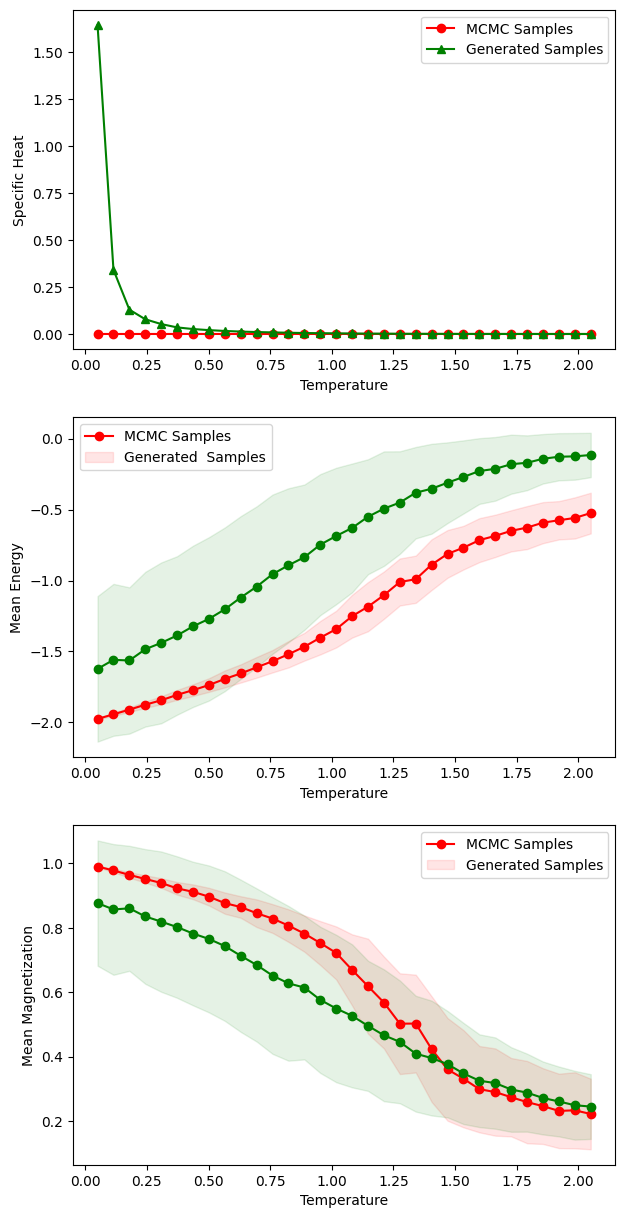

In [44]:
comparison_plot(lattices1,samples,1000,0.05,2.05,num_classes,J=1,K=0,name='./hgvae_samples/8x8/comparison_plot_ckpt_1')

In [42]:
evaluation_metrics(lattices1,samples,0.05,2.05,num_classes,J=1,K=0)

[[26.178755946272993, 3.836428941316933],
 [62.5875, 20.75416750317873],
 [0.16706171875000003, 0.03140320288972764],
 [0.100584375, 0.061293778280175994]]

In [45]:
output = open('./hgvae_samples/8x8/lattices_ckpt_1.pkl', 'wb')
pickle.dump(samples, output)
output.close()